<a href="https://colab.research.google.com/github/nisaruj/Chemception-plus/blob/master/Chemception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Install packages

In [ ]:
!pip install -q pubchempy

In [ ]:
!pip install -q image-classifiers

     |████████████████████████████████| 51kB 2.0MB/s 


In [ ]:
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local 
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

### Import mapping data

In [ ]:
!wget -q https://github.com/nisaruj/Chemception-plus/raw/master/data/nsc_smiles.pickle

In [ ]:
# !cp drive/My\ Drive/BIOINFO/nsc_smiles.pickle ./nsc_smiles.pickle

### Import dataset

In [ ]:
!wget -q -O dataset.csv https://raw.githubusercontent.com/nisaruj/Chemception-plus/master/data/aids_conc_may04.csv

In [ ]:
# !cp drive/My\ Drive/BIOINFO/aids_conc_may04.txt ./dataset.csv
# Trim whitespaces from dataset file
# !sed -r "s/[ \t]//g" dataset.csv > out.csv
# !mv out.csv dataset.csv

## Preprocess

CNN requires 2D matrix so we need to convert NSC id -> -> SMILES -> 2D grid image

### Visualize dataset

* CA - Confirmed active
* CM - Confirmed moderately active
* CI - Confirmed inactive

In [ ]:
import pandas as pd

data = pd.read_csv("dataset.csv")
data.head(5)

,NSC,Conclusion
0,48,CI
1,78,CI
2,128,CI
3,163,CI
4,164,CI


We use NSC dataset which uses an internal id to identify a molecule so we need to create a mapping that converts NSC id to SMILES.

We can use PubChem api to retrieve smiles from NSC id

In [ ]:
import pubchempy as pcp
pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC170', 'name')

[{'CID': 219201,
  'CanonicalSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC',
  'IsomericSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC'}]

In [ ]:
# from progressbar import progressbar

# NSC2SMILES = {}
# start_from = 722245
# for compound_id in progressbar(data['NSC']):
#   if compound_id in NSC2SMILES:
#     continue
#   if compound_id < start_from:
#     continue
#   props = pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC' + str(compound_id), 'name')
#   if len(props) > 0:
#     NSC2SMILES[compound_id] = props[0]

In [ ]:
# import pickle

# with open('nsc_smiles.pickle', 'wb') as handle:
#     pickle.dump(NSC2SMILES, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

with open('nsc_smiles.pickle', 'rb') as fp:
  NSC2SMILES = pickle.load(fp)
  
len(NSC2SMILES)

42407

In [ ]:
NSC2SMILES[7816]

{'CID': 73120,
 'CanonicalSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl',
 'IsomericSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl'}

We remove the data that isn't compound (ie. substance).

In [ ]:
data['is_compound'] = data['NSC'].isin(NSC2SMILES)
data = data[data['is_compound'] == True]

Like the paper, the problem was reduced to binary classification by setting CI to 0 and CM/CA to 1.

In [ ]:
data['active'] = data['Conclusion'].isin(['CM', 'CA'])
data.head(5)

,NSC,Conclusion,is_compound,active
2,128,CI,True,False
3,163,CI,True,False
4,164,CI,True,False
5,170,CI,True,False
6,180,CI,True,False


Counter({False: 40859, True: 1548})


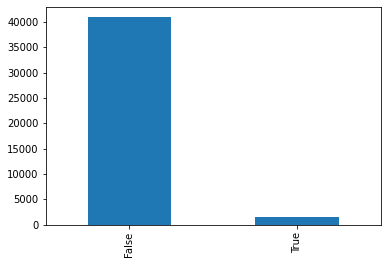

In [ ]:
from collections import Counter
print(Counter(data['active']))

data['active'].value_counts().plot(kind='bar');

### Chemcepterize NSC compound

`chemcepterizeFromNsc` converts a molecule into a color-coded grid image.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def molFromNsc(nsc):
  return Chem.MolFromSmiles(NSC2SMILES[nsc]['IsomericSMILES'])

def drawFromNsc(nsc):
  Draw.MolToMPL(molFromNsc(nsc), size=(100, 100))

'''
https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/
Note that the code above uses 4 channel image but the paper uses only 1 channel (greyscale).

@param embed
@param res - Resolution of each pixel (Å)
'''
def chemcepterizeFromNsc(nsc, embed=20.0, res=0.5):
    mol = molFromNsc(nsc)
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    Chem.AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    # vect = np.zeros((dims,dims,4))
    vect = np.zeros((dims,dims,1))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2))
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            # vect[ idx , idy ,0] = bondorder
            vect[idx , idy, 0] = 2
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            # vect[ idx , idy, 1] = atom.GetAtomicNum()
            vect[idx , idy, 0] = atom.GetAtomicNum()
            #Gasteiger Charges
            # charge = atom.GetProp("_GasteigerCharge")
            # vect[ idx , idy, 3] = charge
            #Hybridization
            # hyptype = atom.GetHybridization().real
            # vect[ idx , idy, 2] = hyptype
    return vect

def drawChemceptionVector(v):
  plt.imshow(v[:,:,0])

def drawChemceptionFromNsc(nsc, embed=20.0, res=0.5):
  v = chemcepterizeFromNsc(nsc, embed=embed, res=res)
  drawChemceptionVector(v)

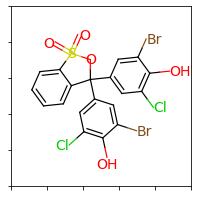

In [ ]:
drawFromNsc(7816)

(40, 40, 1)


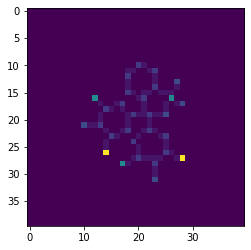

In [ ]:
v = chemcepterizeFromNsc(7816, embed=10)
print(v.shape)
drawChemceptionFromNsc(7816, embed=10)

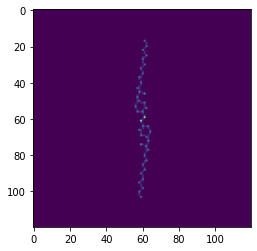

In [ ]:
drawChemceptionFromNsc(220, embed=30)

### Preprocess data

In [ ]:
import numpy as np
from progressbar import progressbar

data_X = []
data_y = []

for idx, row in progressbar(data.iterrows()):
  try:
    img = chemcepterizeFromNsc(row['NSC'], embed=20)
    data_X.append(img)
    data_y.append(row['active'])
  except:
    # Remove bad data (eg. out of bound)
    pass

data_X = np.array(data_X)
data_y = np.array(data_y)

| |           #                                   | 42406 Elapsed Time: 0:03:53


In [ ]:
print(data_X.shape)
print(data_y.shape)

(42228, 80, 80, 1)
(42228,)


Stratify the data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, stratify=data_y, test_size=1/6)

print(len(X_train), len(X_test))
print(Counter(y_train), Counter(y_test))

35190 7038
Counter({False: 33928, True: 1262}) Counter({False: 6785, True: 253})


In [ ]:
with open('split_data.pickle', 'wb') as handle:
  data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
  }
  pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp split_data.pickle drive/My\ Drive/BIOINFO/split_data.pickle

## Model

In [ ]:
from classification_models.tfkeras import Classifiers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def get_model(model_name):
  ClsModel, preprocess_input = Classifiers.get(model_name)

  # X = preprocess_input(X_train)
  # Xt = preprocess_input(X_test)

  # build model
  base_model = ClsModel(input_shape=(80,80,1), include_top=False)
  x = GlobalAveragePooling2D()(base_model.output)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=[base_model.input], outputs=[output])
  return model

In [ ]:
# train
model_name = 'resnext50'
model = get_model(model_name)
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test))
model.save(model_name + '.h5')

1100/1100 [==============================] - 7747s 7s/step - loss: 0.2014 - accuracy: 0.9600 - val_loss: 0.2759 - val_accuracy: 0.9641


In [ ]:
!cp model.h5 drive/My\ Drive/BIOINFO/seresnext50.h5
# !cp drive/My\ Drive/BIOINFO/resnet34.h5 resnet34.h5

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def benchmark(model, filename='result.pickle'):
  y_pred = model.predict(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  auc_score = auc(fpr, tpr)
  print('AUC:', auc_score)
  result = {
      "auc": auc_score,
      "fpr": fpr,
      "tpr": tpr,
      "thresholds": thresholds
  }
  with open(filename, 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

  plt.plot(fpr, tpr)
  plt.title("ROC Curve (%s)" % (filename,))
  plt.show()

AUC: 0.606810244639856


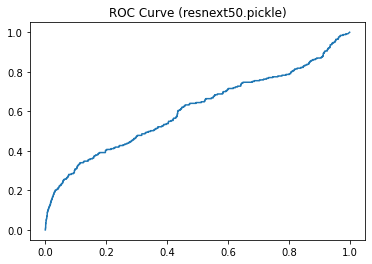

In [ ]:
from tensorflow.keras.models import load_model

model_name = 'resnext50'
# model = load_model(model_name + '.h5')
benchmark(model, model_name + '.pickle')

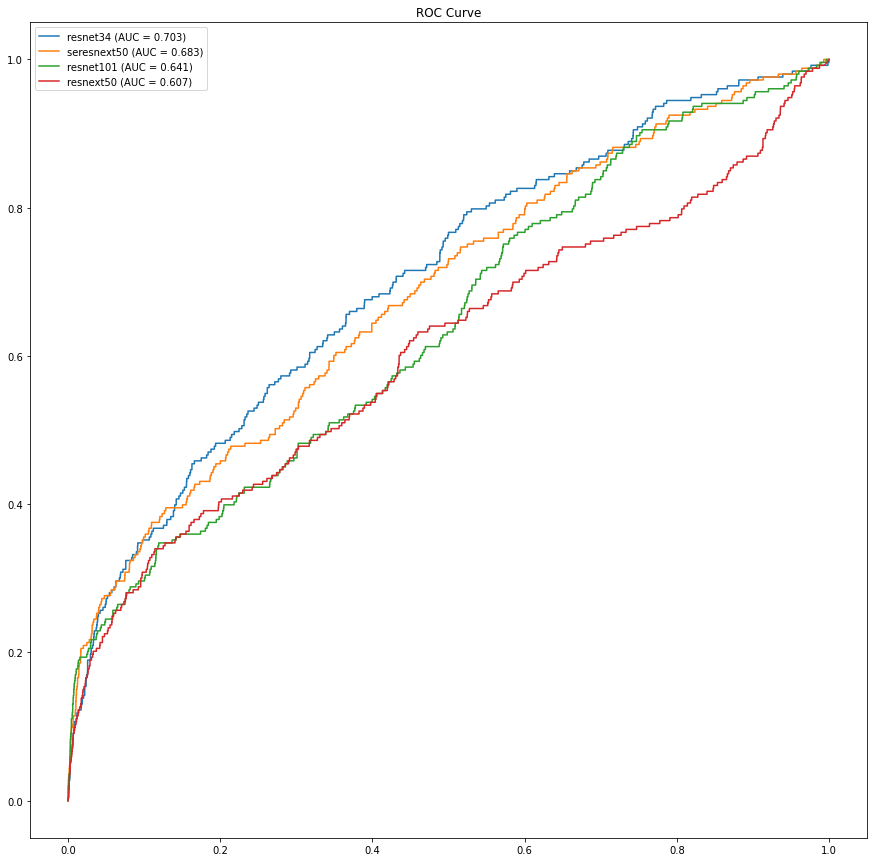

In [ ]:
def plot_results():
  model_names = ['resnet34', 'seresnext50', 'resnet101', 'resnext50']
  plt.figure(figsize=(15, 15))
  for model_name in model_names:
    with open(model_name + '.pickle', 'rb') as fp:
      result = pickle.load(fp)
      plt.plot(result["fpr"], result["tpr"], label=model_name + ' (AUC = %.3f)' % (result["auc"]))
  plt.title("ROC Curve")
  plt.legend()
  plt.show()

plot_results()